In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.io import loadmat
from scipy import signal
from sklearn.preprocessing import scale
import mne
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.tools import module_util
warnings.filterwarnings('ignore')

In [44]:
sim_signals = np.load("sim_input.npy")     
sim_flashing = np.load("sim_flashing.npy") 
sim_stimulus = np.load("sim_stimulus.npy")  
sim_targets = np.load("sim_targets.npy") 
print(sim_signals.shape)
print(sim_flashing.shape)
print(sim_stimulus.shape)
print(sim_targets.shape)
model_path=r"C:\Users\Delll\cnn1_A&B_simulation\model.weights.h5"

(125, 7794, 64)
(125, 7794)
(125, 7794)
(125,)


In [45]:
signals_test = sim_signals
flashing_test = sim_flashing
stimulus_code_test = sim_stimulus
word_test = np.array([''.join(sim_targets)])


SAMPLING_FREQUENCY = 240
# From the dataset description we know that there are 15 repetitions
REPETITIONS = 15
# Compute the duration of the recording in minutes
RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
# Compute number of trials
TRIALS_TEST = len(word_test[0])
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

print("**********************************")
print("        TEST SET INFORMATION      ")
print("**********************************")
print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
print("Number of letters:  %d" % TRIALS_TEST)
print("Number of samples for each character in trials:  %d" % SAMPLES_PER_TRIAL_TEST)
print("Spelled word:  %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   67.66 min
Number of letters:  125
Number of samples for each character in trials:  7794
Spelled word:  XPLZCOR7FZDEZ1PI9NNVRQJURMEUOOOJUYP6GYEGA5HNXOOTDOLEEFAEEWK4R3UMRMROOMUXJOHUVEOGLOOADEFTWEOALZP9OCGE1YQU7K_YJDVDNXDBV2B5FDIDR


In [46]:
import string
import numpy as np

# Create characters matrix (6*6) all values =0
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]  # Columns
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]  # Rows
    list_matrix.append(row)

print('list_matrix :')  # 0:11 (0:5 columns , 6:11 rows)
for idx, item in enumerate(list_matrix):
    if idx < 6:
        print(item, 'column ' + str(idx + 1))
    else:
        if idx == 6:
            print('-' * 40)
        print(item, 'row ' + str(idx - 5))


# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

# Processing test data
for trial in range(TRIALS_TEST):
    counter = 0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

# Now stimulus_test is ready for use.


list_matrix :
['A', 'G', 'M', 'S', 'Y', '5'] column 1
['B', 'H', 'N', 'T', 'Z', '6'] column 2
['C', 'I', 'O', 'U', '1', '7'] column 3
['D', 'J', 'P', 'V', '2', '8'] column 4
['E', 'K', 'Q', 'W', '3', '9'] column 5
['F', 'L', 'R', 'X', '4', '_'] column 6
----------------------------------------
['A', 'B', 'C', 'D', 'E', 'F'] row 1
['G', 'H', 'I', 'J', 'K', 'L'] row 2
['M', 'N', 'O', 'P', 'Q', 'R'] row 3
['S', 'T', 'U', 'V', 'W', 'X'] row 4
['Y', 'Z', '1', '2', '3', '4'] row 5
['5', '6', '7', '8', '9', '_'] row 6


In [47]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [48]:
# Down-sampling of the signals from 240Hz to 120Hz
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]
stimulus_code_test = stimulus_code_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [49]:
# Number of EEG channels
CHANNELS = [i for i in range(64)]
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals_test[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            #print(f"stimulus_test shape: {stimulus_test.shape}")
            #print(f"Current trial: {trial}, Current sample: {sample}")

            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (22500, 78, 64)


In [50]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

In [51]:
# Randomizing function for bias and weights of the network
def cecotti_normal(shape, dtype = None, partition_info = None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    return tf.random.normal(shape, mean = 0.0, stddev = (1.0 / fan_in))

In [52]:
# Custom tanh activation function
def scaled_tanh(z):
    return 1.7159 * tf.tanh((2.0 / 3.0) * z)

In [53]:
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D
# Build the model
def CNN1_model(channels=64, filters=10):
    model = Sequential([
            Conv1D(
                filters = filters,
                kernel_size = 1,
                padding = "same",
                bias_initializer = cecotti_normal,
                kernel_initializer = cecotti_normal,
                use_bias = True,
                activation = "relu",
                input_shape = (78, channels),
                #kernel_regularizer=L2(0.01)
                  ),
            Dropout(0.1),
            Conv1D(
                filters = 55,
                kernel_size = 13,
                padding = "valid",
                strides = 11,
                bias_initializer = cecotti_normal,
                kernel_initializer = cecotti_normal,
                use_bias = True,
                activation = "relu"
                  ),
            Dropout(0.25),
            Flatten(),
            Dense(100, activation="relu"),
            Dropout(0.35),
            Dense(30, activation="relu"),
            Dropout(0.1),
            Dense(1, activation="sigmoid")
        ])
    model.compile(optimizer = Adam(0.001), loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

In [54]:
from tensorflow.keras.optimizers import Adam 
channels = 64
filters = 10
model = CNN1_model(channels, filters)
model.load_weights("D:/DOCS/Desktop/P300 PY/model.weights.h5")

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_dict = {1: model}

In [55]:
# Accuracy over the testing set
predictions = model.predict(test_features).flatten()

# Model evaluation
score = sum(test_labels[i] == predictions[i].round() for i in range(len(test_labels))) / len(predictions)

# Print accuracy
print("Model CNN1: accuracy on test set: {}%".format(round(score * 100, 4)))


704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step
Model CNN1: accuracy on test set: 72.6178%


In [56]:
y_probs = model.predict(test_features)

threshold = 0.5
predictions = (y_probs >= threshold).astype(int)

from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy with threshold {threshold}: {accuracy:.4f}")
print(classification_report(test_labels, predictions))

704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step
Accuracy with threshold 0.5: 0.7262
              precision    recall  f1-score   support

           0       0.91      0.74      0.82     18750
           1       0.33      0.64      0.44      3750

    accuracy                           0.73     22500
   macro avg       0.62      0.69      0.63     22500
weighted avg       0.82      0.73      0.76     22500



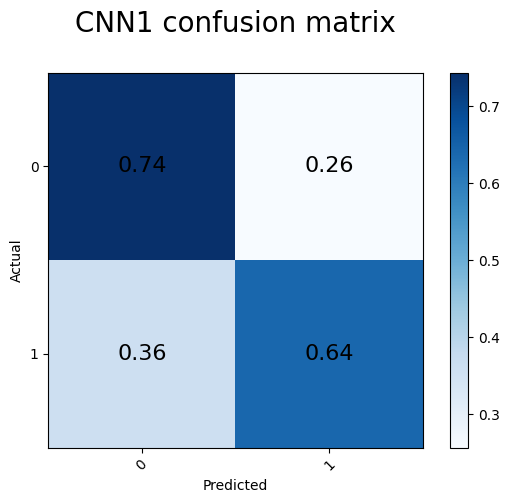

In [57]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

plt.figure(figsize=(6, 5))
plt.imshow(data_norm, interpolation='nearest', cmap='Blues')
plt.title("CNN1 confusion matrix\n", fontsize=20)
plt.colorbar()
classes = np.unique(test_labels)
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{data_norm[i, j]:.2f}', ha="center", va="center", color="black", fontsize=16)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [58]:
# If intersection is valid (row-col) and returns char, otherwise returns none
def check_letter(x, y):
    # Check if x and y are two columns or two rows
    if ((x >= 1 and x <= 6) and (y >= 1 and y <= 6)) or ((x >= 7 and x <= 12) and (y >= 7 and y <= 12)):
        return None
    else:
        list1 = list_matrix[x - 1]
        list2 = list_matrix[y - 1]
        for c in list1:
            # If char is also in list2, it is the intesection of col and row
            if c in list2:
                return c

In [59]:
# Returns the intersection for all permutations of columns and rows
def check_intersect(list_colrow):
    intersect = []
    for x in range(len(list_colrow)-1):
        for y in range(x+1, len(list_colrow)):
            tmp = check_letter(list_colrow[x], list_colrow[y])
            if tmp:
                intersect.append(tmp)
    return intersect

In [60]:
# Keeps track of multiple occurrences during epochs
def dict_predictions(predictions, stimulus, n_epoch, A=1, B=0):
    # A: Certainty decreses with number of possible guesses
    # B: Certainty increases with number of epochs processed
    dict_char = {}
    for epoch in range(1, n_epoch + 1):
        list_flash = []
        for index in range(12):
            # Obtain single epoch of data
            pred = predictions[12*(epoch-1):12*epoch]
            stim = stimulus[12*(epoch-1):12*epoch]
            # Sort pred following 1->12 col/row ordering
            sorted_pred = sort_predictions(pred, stim)
            # Round predictions to contain only 1 and 0
            round_pred = round_argmax(sorted_pred)
            # Append cols and rows number where there's a flash
            if round_pred[index] == 1:
                list_flash.append(index+1)
        # Get all intersections and create dict with all occurrences
        intersect = check_intersect(list_flash)
        for inter in intersect:
            if inter not in dict_char.keys():
                dict_char[inter] = A*(1/len(intersect)) + B*((epoch+1)/n_epoch)
            else:
                dict_char[inter] += A*(1/len(intersect)) + B*((epoch+1)/n_epoch)
    return dict_char

In [61]:
# Get list of all char predictions
def char_predictions(sorted_pred):
    # Precodition1: sorted_pred sorteded by col/row enumeration
    # Precodition2: takes only 1 epoch at the time
    list_flash = []
    for index in range(12):
        if sorted_pred[index] == 1:
            list_flash.append(index + 1)
    intersect = check_intersect(list_flash)
    return intersect

In [62]:
# Rounds and adjusts predictions to contain two 1 and ten 0
def round_argmax(sorted_pred):
    # Precodition1: sorted_pred sorteded by col/row enumeration
    # Precodition2: takes only 1 epoch at the time
    adjust_cols = [0 for i in range(6)]
    adjust_rows = [0 for i in range(6)]
    sortcols = list(sorted_pred[:6])
    sortrows = list(sorted_pred[6:])
    sortcols.sort()
    sortrows.sort()
    for i in range(6):
        if sorted_pred[i] == sortcols[-1]:
            adjust_cols[i] = 1
    for i in range(6):
        if sorted_pred[6+i] == sortrows[-1]:
            adjust_rows[i] = 1
    return adjust_cols + adjust_rows

In [63]:
# Sort pred following 1->12 col/row ordering
def sort_predictions(predictions, stimulus):
    # Precondition: takes only 1 epoch at the time
    sorted_pred = [0 for i in range(12)]
    for index in range(12):
        sorted_pred[int(stimulus[index]) - 1] = predictions[index]
    return sorted_pred

In [64]:
# Estimate the expected values for each prediction in n epochs
def mean_predictions(predictions, stimulus, n_epoch):
    epoch_matrix = []
    for epoch in range(1, n_epoch + 1):
        # Obtain single epoch of data
        pred = predictions[12*(epoch-1):12*epoch]
        stim = stimulus[12*(epoch-1):12*epoch]
        # Sort pred following 1->12 col/row ordering
        sorted_pred = sort_predictions(pred, stim)
        # Append sorted epoch of pred into matrix
        epoch_matrix.append(sorted_pred)
    # Mean over n_epochs to improve estimation of prediction
    return np.array(epoch_matrix).mean(axis=0)

In [65]:
# In case of ties we look at the occurrences to find the most probable
def break_ties(word_pred, dict_pred):
    max_occ = 0
    max_pred = None
    letters = []
    results = []
    for letter in word_pred:
        if letter in dict_pred.keys():
            letters.append(letter)
            if dict_pred[letter] > max_occ:
                max_occ = dict_pred[letter]
    # We found a least 1 letter in the dict
    if max_occ > 0:
        for letter in letters:
            if dict_pred[letter] == max_occ:
                results.append(letter)
    # If the tie still holds, return random element from results
    if results:
        return random.choice(results)
    else:
        return random.choice(word_pred)

In [66]:
import random

speller_pred = {}
epochs_score = []
for epoch in range(1, 12 + 1):
    score = 0
    speller_list = []
    for n_char in range(len(word_test[0])):
        # Ordering of predictions following col/row enumeration and then estimate expected values
        v = mean_predictions(predictions[n_char*180 : n_char*180+12*epoch], windowed_stimulus[n_char*180 : n_char*180+12*epoch], epoch)
        # x = argmax v(i) for 1<=i<=6, y = argmax v(i) for 7<=i<=12 [x: col P300 detection, y: row P300 detection]
        round_v = round_argmax(v)
        # Get intersection letter/s in the char matrix
        word_pred = char_predictions(round_v)
        # Get dictionary with all char occurrences during epochs
        dict_pred = dict_predictions(predictions[n_char*180 : n_char*180+12*epoch], windowed_stimulus[n_char*180 : n_char*180+12*epoch], epoch)
        # Break the tie by comparison between word_pred and dict_pred
        final_pred = break_ties(word_pred, dict_pred)
        # Calculate speller model performance
        speller_list.append(final_pred)
        if (word_test[0][n_char] == final_pred):
            score += 1
    # Save speller predictions per epoch
    speller_pred[epoch] = speller_list
    epochs_score.append(score)
    print("Epoch #{}\tAccuracy: {}%".format(epoch, score))


Epoch #1	Accuracy: 15%
Epoch #2	Accuracy: 31%
Epoch #3	Accuracy: 41%
Epoch #4	Accuracy: 49%
Epoch #5	Accuracy: 58%
Epoch #6	Accuracy: 69%
Epoch #7	Accuracy: 72%
Epoch #8	Accuracy: 81%
Epoch #9	Accuracy: 86%
Epoch #10	Accuracy: 91%
Epoch #11	Accuracy: 93%
Epoch #12	Accuracy: 101%


In [67]:
print(''.join(speller_pred[12]))
print(word_test[0])

EPLZFUR7BZDEZ1QI9NNDRQDURMEUO1OJUYP9G3EGA8HBXOOTDOLE3FA3AWKOR2UMRMMOOMOXJOHUVKOGLOOADFFTWEOALZP9ICGE1YKU7K_YJDVDNXDBV2B7FDIDR
XPLZCOR7FZDEZ1PI9NNVRQJURMEUOOOJUYP6GYEGA5HNXOOTDOLEEFAEEWK4R3UMRMROOMUXJOHUVEOGLOOADEFTWEOALZP9OCGE1YQU7K_YJDVDNXDBV2B5FDIDR


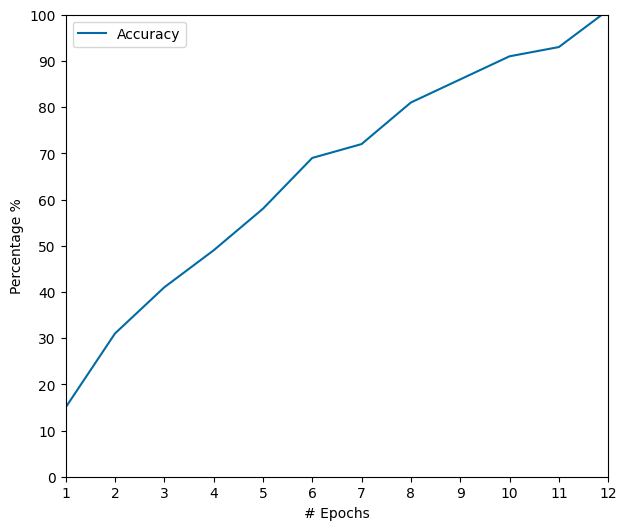

In [68]:
plt.figure(figsize=(7,6))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,1,1)
plt.plot(np.linspace(1,12,12), epochs_score, label="Accuracy")
plt.xticks([i for i in range(1,13,1)])
plt.yticks([i for i in range(0,110,10)])
ax = plt.gca()
ax.set_xlim([1,12])
ax.set_ylim([0,100])
plt.xlabel("# Epochs")
plt.ylabel("Percentage %")
plt.grid(True, which='major', color='#FFFFFF', linestyle='-')
plt.legend()

plt.show()

In [69]:
pred = ''.join(speller_pred[12])
true = word_test[0]

correct = sum(p == t for p, t in zip(pred, true))
total = len(true)
wrong = total - correct

print(f"Total letters: {total}")
print(f"Correct letters: {correct}")
print(f"Wrong letters: {wrong}")
print(f"Accuracy: {correct / total * 100:.2f}%")

Total letters: 125
Correct letters: 101
Wrong letters: 24
Accuracy: 80.80%


In [70]:
with open("predicted_word_on_simulation_data.txt", "w") as f:
    f.write(''.join(speller_pred[12]))